![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/90.5.Financial_Visual_NER_Position_Finder.ipynb)

## Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import *

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

In [ ]:
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.utils import display_image, display_pdf
from sparkocr.transformers import *

In [ ]:
from johnsnowlabs import nlp, finance, visual
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

spark

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.4.1, 💊Spark-Healthcare==4.4.2, 🕶Spark-OCR==4.4.1, running on ⚡ PySpark==3.1.2


## Define OCR transformers and pipeline

In [ ]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_text = visual.PdfToText() \
        .setInputCol("content") \
        .setOutputCol("text") \
        .setSplitPage(True) \
        .setStoreSplittedPdf(True) \
        .setExtractCoordinates(True)
    
    document_assembler = nlp.DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

    sentence_detector = finance.TextSplitter() \
        .setInputCols(["document"]) \
        .setOutputCol("sentence")

    tokenizer = nlp.Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")\
        .setContextChars(['.', ',', ';', ':', '!', '?', '*', '-', '(', ')', '"', "'", '%', '&'])

    ner_model = finance.BertForTokenClassification.pretrained("finner_responsibility_reports", "en", "finance/models")\
        .setInputCols(["sentence", "token"])\
        .setOutputCol("ner")\
        .setCaseSensitive(True)\
        .setMaxSentenceLength(512)

    ner_converter = nlp.NerConverter()\
        .setInputCols(["sentence", "token", "ner"])\
        .setOutputCol("ner_chunk")

    position_finder = visual.PositionFinder() \
        .setInputCols("ner_chunk") \
        .setOutputCol("coordinates") \
        .setPageMatrixCol("positions") \
        .setPadding(1)

    draw = visual.PdfDrawRegions() \
        .setInputRegionsCol("coordinates") \
        .setOutputCol("pdf_with_regions") \
        .setInputCol("content") \
        .setLineWidth(1)
    
    pipeline = nlp.Pipeline(stages=[
        pdf_to_text,
        document_assembler,
        sentence_detector,
        tokenizer,
        ner_model,
        ner_converter,
        position_finder,
        draw 
    ])
    
    return pipeline

## Read PDF document as binary file

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/solution_accelerator_esg_and_rr/res_report_page.pdf


    Image #0:
    Origin: file:/content/pages-16.pdf
    Resolution: 300 dpi
    Width: 5691 px
    Height: 3200 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


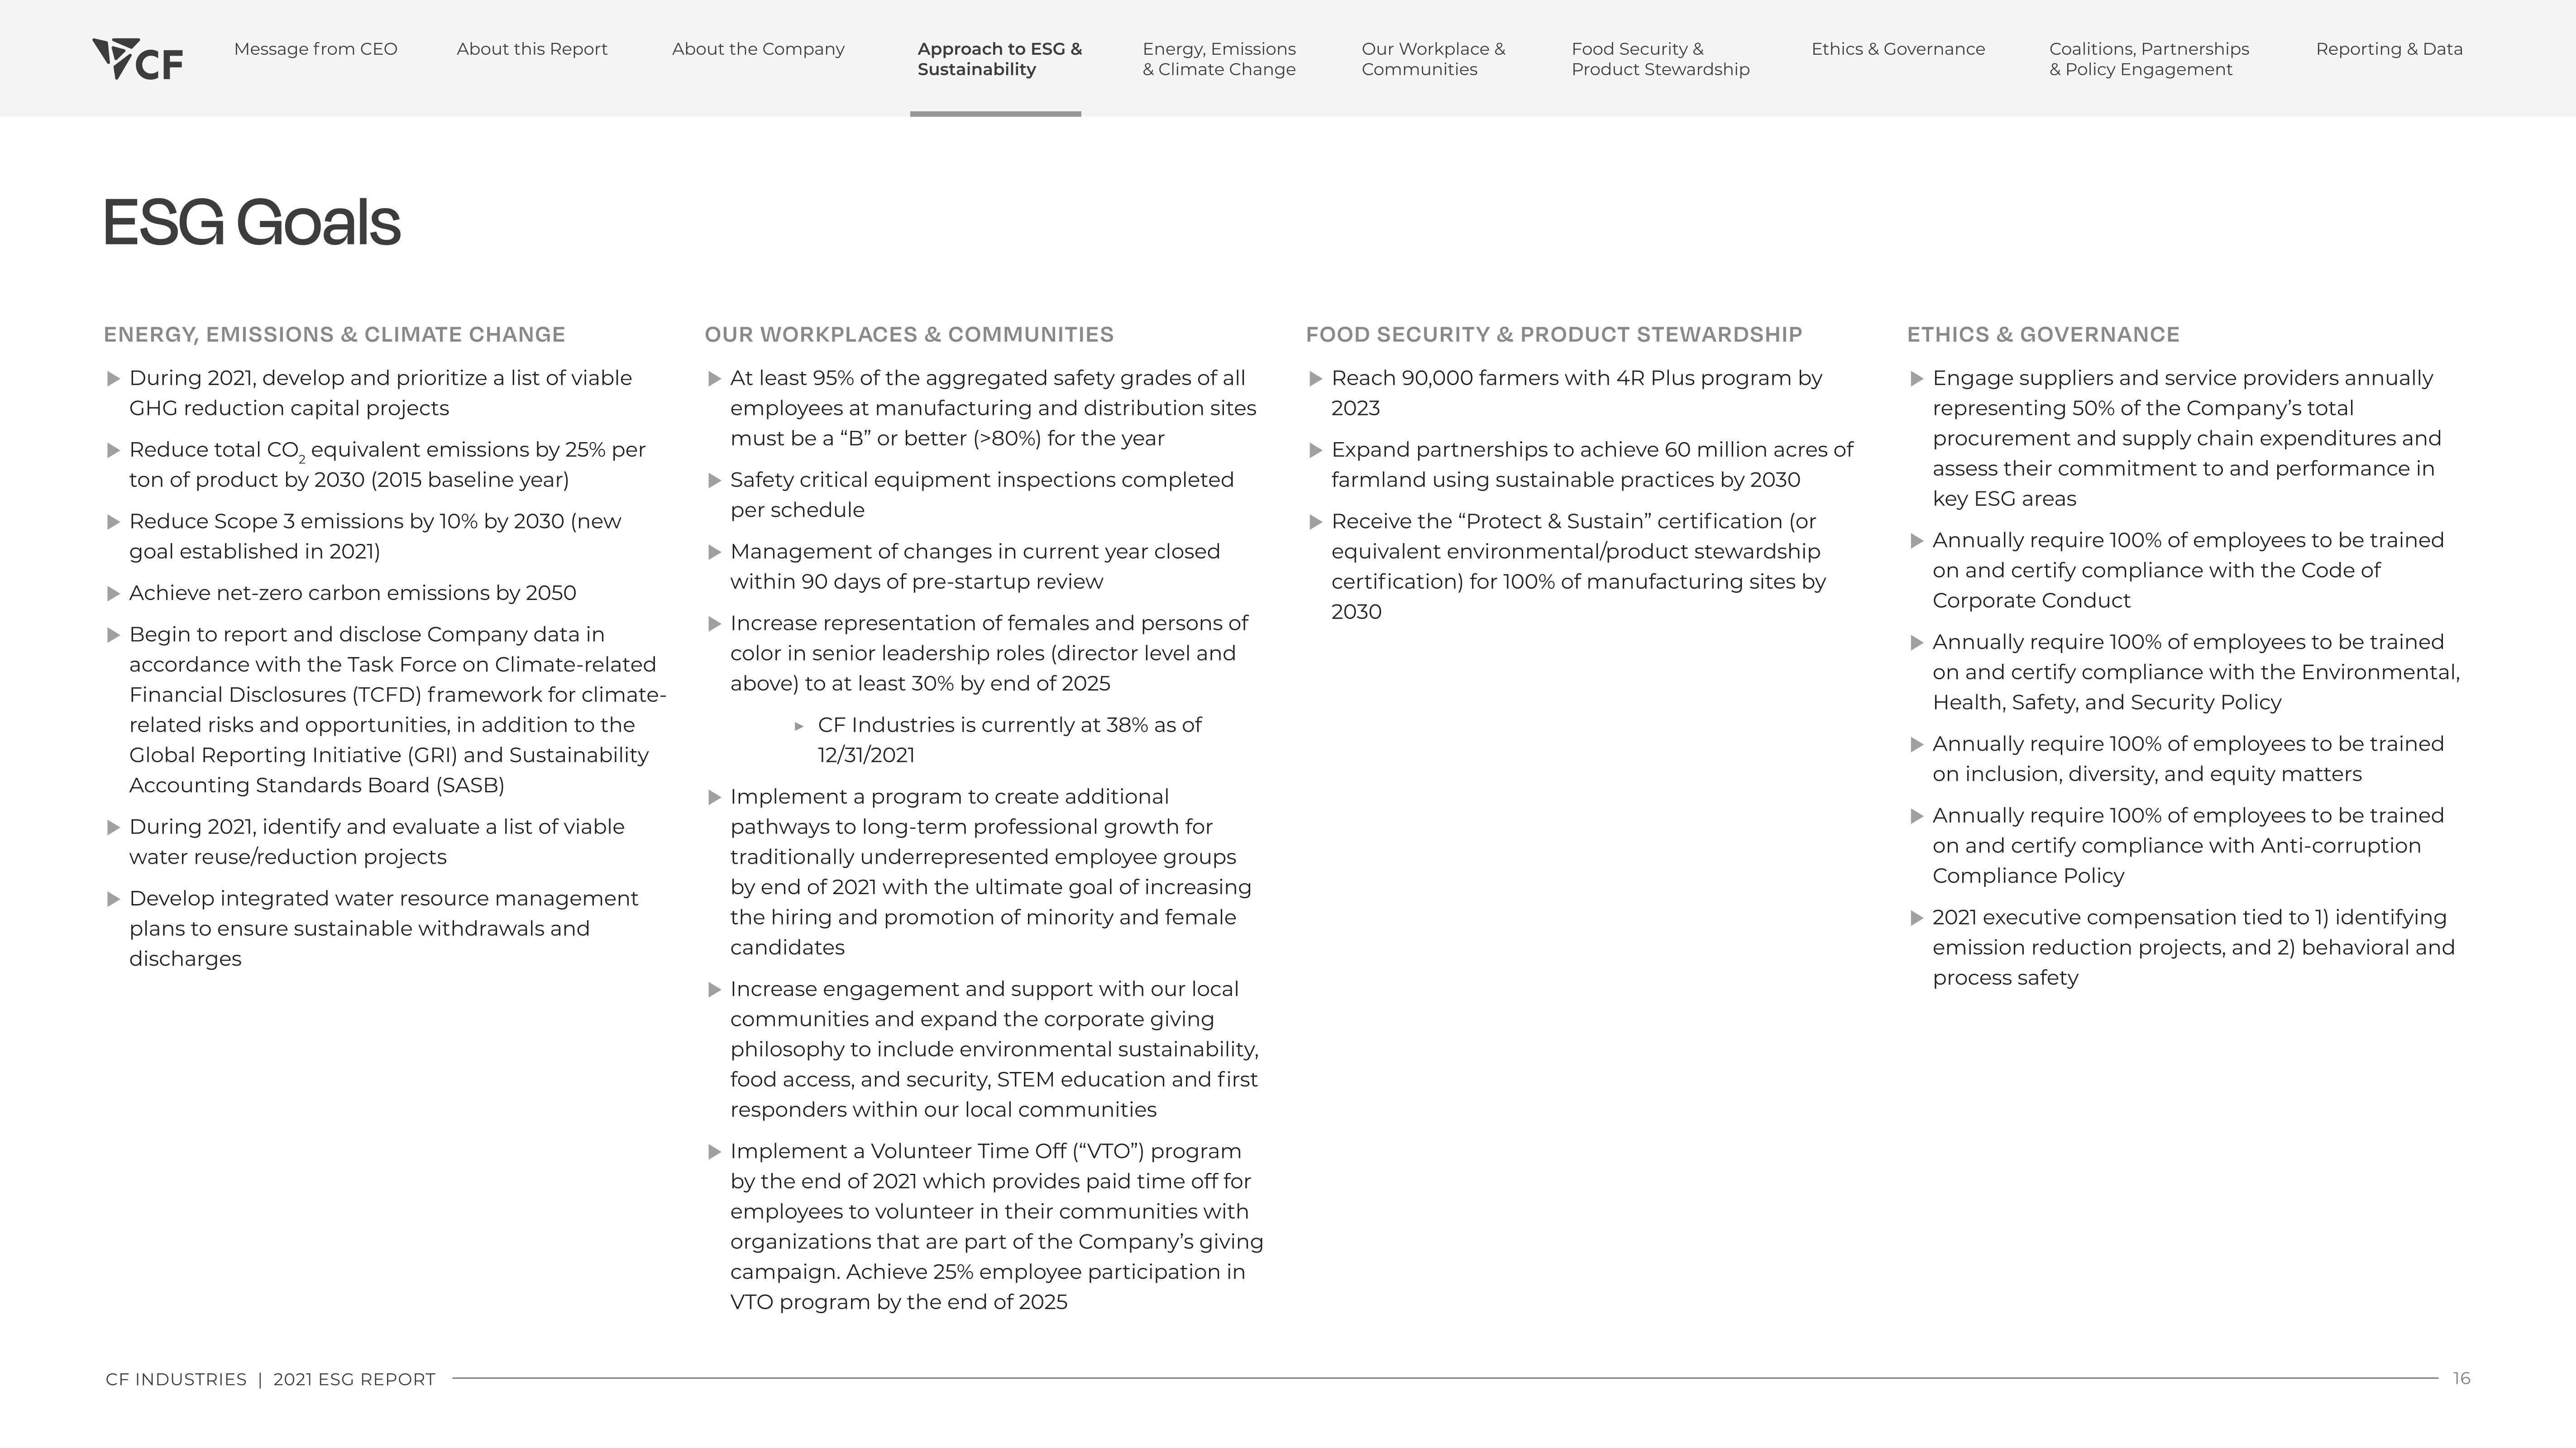

In [ ]:
pdf_path = './res_report_page.pdf'

pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()

visual.display_pdf(pdf_example_df)

In [ ]:
result = pipeline().fit(pdf_example_df).transform(pdf_example_df).cache()

finner_responsibility_reports download started this may take some time.
[OK!]


## Display results

In [ ]:
result.select("ner_chunk", "coordinates").show()

+--------------------+--------------------+
|           ner_chunk|         coordinates|
+--------------------+--------------------+
|[{chunk, 48, 58, ...|[{0, 0, 68.4969, ...|
+--------------------+--------------------+



## Store results to pdf file

In [ ]:
pdf = result.select("pdf_with_regions").head().pdf_with_regions
pdfFile = open("result.pdf", "wb")
pdfFile.write(pdf)

55478

## Convert pdf to image and display 


    Image #0:
    Origin: file:/content/pages-16.pdf
    Resolution: 300 dpi
    Width: 5691 px
    Height: 3200 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


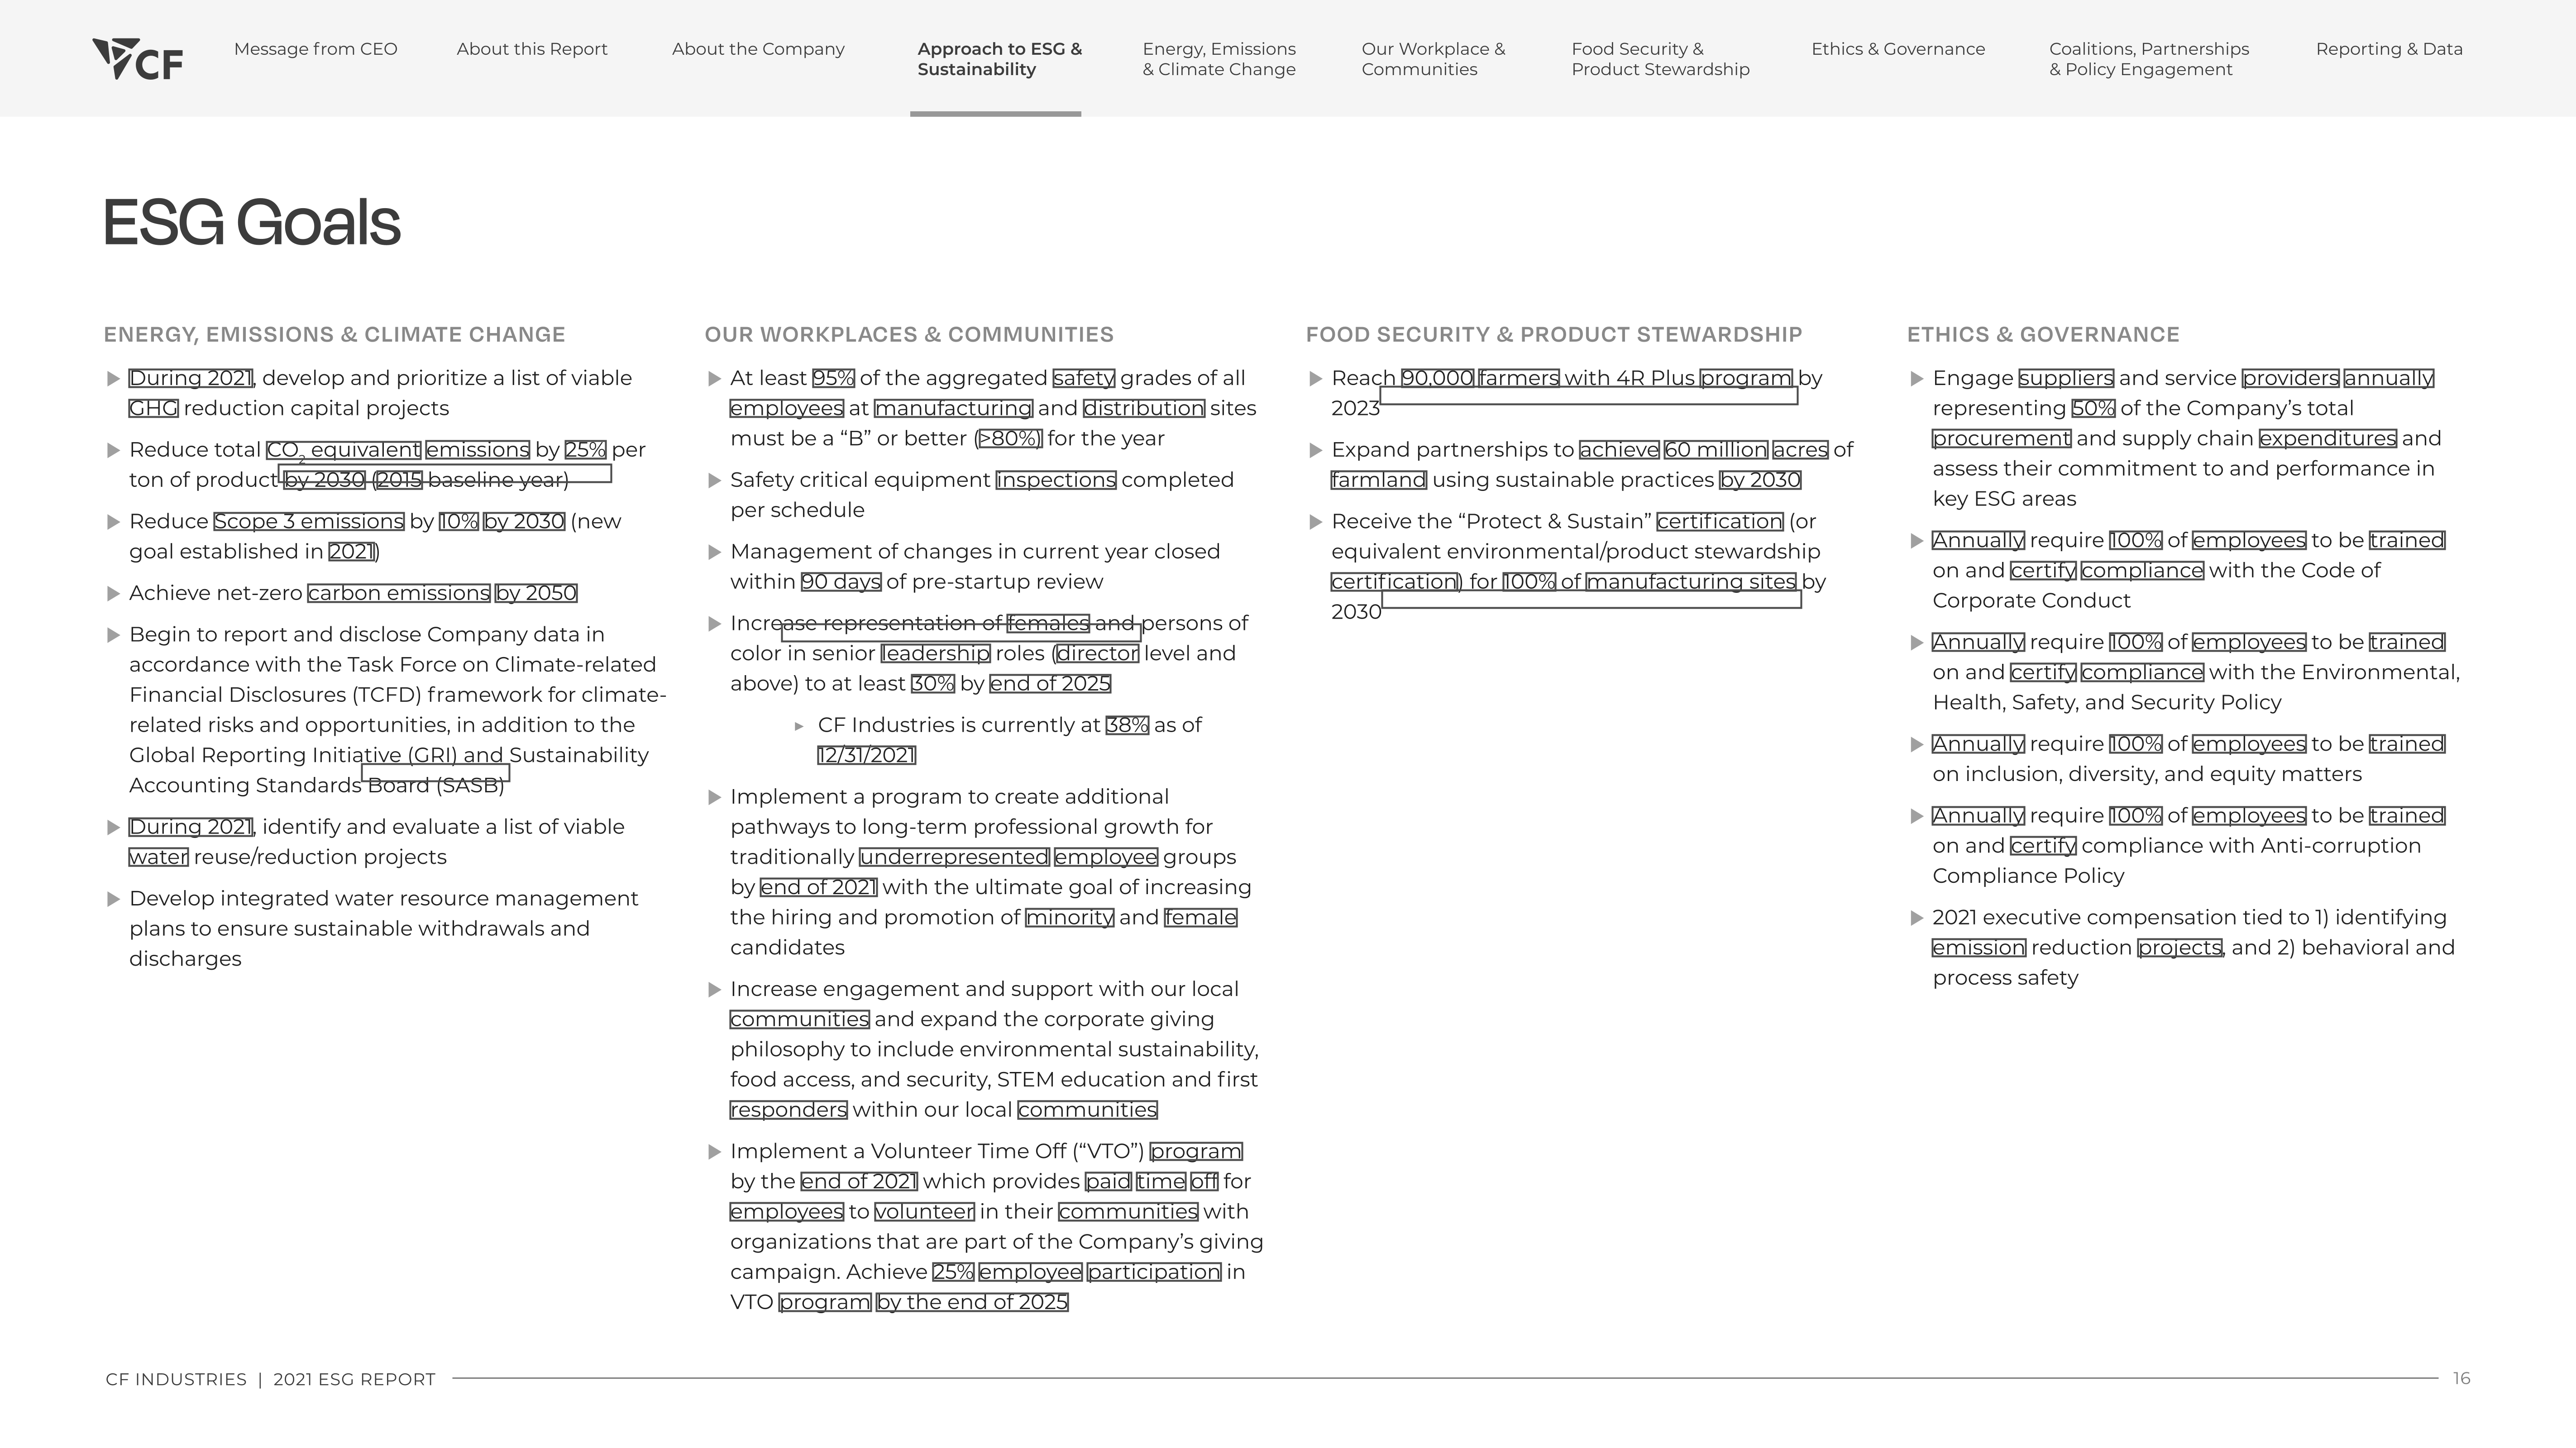

In [ ]:
display_pdf(result.select("pdf_with_regions", "path"), field="pdf_with_regions")

In [ ]:
#%%bash
#rm -r -f result.pdf